In [2]:
import os

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec as gridspec
import dill

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
sparse_mice = stx.ymaze_sess_deets.sparse_mice

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
from STX3KO_analyses.path_dicts.path_dict_esay import path_dictionary as path_dict
pkl_base_dir = path_dict['pkl_root']


In [4]:
sparse_sessions.keys()

dict_keys(['SparseKO_05', 'SparseKO_02', 'SparseKO_03', 'SparseKO_06', 'SparseKO_08', 'SparseKO_09', 'SparseKO_10', 'SparseKO_11', 'SparseKO_13'])

In [45]:
mouse = 'SparseKO_13'
d = sparse_sessions[mouse][9]
print(d)

{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}


In [46]:
date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']
print(scene)
# basedir = f'/mnt/BigDisk/2P_scratch/{mouse}/{date}/{scene}'
# basedir = f'C://Users/esay/data/Stx3/{mouse}/{date}/{scene}'
# basedir = f'Z://giocomo/esay/Stx3/2pData/{mouse}/{date}/{scene}'
basedir = f'Z://giocomo/InVivoDA/2P_Data/{mouse}/{date}/{scene}'

stem =  os.path.join(basedir, f'{scene}_{session:03}_{scan:03}')

d.update({'mouse': mouse ,
          'scan_file':stem + '.sbx',
          'scanheader_file': stem + '.mat',
          'vr_filename': os.path.join("Z://giocomo/esay/Stx3/VRData",mouse,date,"%s_%d.sqlite" %(scene,session)),
          'scan_number': scan,
          'prompt_for_keys': False,
          'VR_only': False,
          'scanner': "NLW",
          'n_channels':2,
             })

YMaze_LNovel


In [7]:
d

{'date': '27_05_2025',
 'scene': 'YMaze_LNovel',
 'session': 1,
 'scan': 22,
 'novel_arm': 1,
 'exp_day': 4,
 'mouse': 'SparseKO_13',
 'scan_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_13/27_05_2025/YMaze_LNovel\\YMaze_LNovel_001_022.sbx',
 'scanheader_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_13/27_05_2025/YMaze_LNovel\\YMaze_LNovel_001_022.mat',
 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_13\\27_05_2025\\YMaze_LNovel_1.sqlite',
 'scan_number': 22,
 'prompt_for_keys': False,
 'VR_only': False,
 'scanner': 'NLW',
 'n_channels': 2}

In [47]:
sess = stx.session.YMazeSession(**d)
sess.load_scan_info(sbx_version=3)
sess.align_VR_to_2P(mux=True)
sess.load_suite2p_data_ES(which_ts=('F', 'Fneu'), mux = True)
sess.get_trial_info()



Fixing teleports
frame rate 31.25
(115005,) ttl times,(46432,) ca2+ frame times
last time: VR 1485.8789375, ca2+ 1485.7920000000001


c:\users\esay\repos\twoputils\TwoPUtils\preprocessing.py:259: UserWarning: Number of teleports and trial starts don't match
  warnings.warn("Number of teleports and trial starts don't match")
c:\users\esay\repos\twoputils\TwoPUtils\preprocessing.py:265: UserWarning: One more trial start than teleport, assuming the final teleport got chopped
  warnings.warn(('One more trial start than teleport, assuming the final teleport got chopped'))


frame rate 31.25
(115005,) ttl times,(46432,) ca2+ frame times
last time: VR 1485.8789375, ca2+ 1485.7920000000001


c:\users\esay\repos\twoputils\TwoPUtils\preprocessing.py:259: UserWarning: Number of teleports and trial starts don't match
  warnings.warn("Number of teleports and trial starts don't match")
c:\users\esay\repos\twoputils\TwoPUtils\preprocessing.py:265: UserWarning: One more trial start than teleport, assuming the final teleport got chopped
  warnings.warn(('One more trial start than teleport, assuming the final teleport got chopped'))


(23216, 17) (23216, 17)
['Z://giocomo/InVivoDA/2P_Data/SparseKO_13/29_05_2025/YMaze_LNovel\\YMaze_LNovel_001_020\\suite2p', 'Z://giocomo/InVivoDA/2P_Data/SparseKO_13/29_05_2025/YMaze_LNovel\\YMaze_LNovel_001_020\\chan2/suite2p']


In [48]:
sess.timeseries['channel_1_F'].shape[1]

23216

In [49]:
sess.vr_data.shape[0]

46432

In [12]:
# modify timeseries for MUXED data (add Nan frames between values to align with lick/speed)

def align_mux(sess):
    for key in list (sess.timeseries.keys()):
        data=sess.timeseries[key]

        if f'channel_0' in key:
            new_data = np.empty((data.shape[0], data.shape[1] *2))
            new_data[:] = np.nan
            new_data[:,::2] = data # place chan0 values at even index

        elif f'channel_1' in key:
            new_data = np.empty((data.shape[0], data.shape[1] *2))
            new_data[:] = np.nan
            new_data[:,1::2] = data # place chan1 values at odd index

        else:
            continue 

        sess.timeseries[key] = new_data

def reverse_mux_alignment(self, df_key = "channel_0_F_dff"):
    df = sess.timeseries[df_key]

    unmux = df[:, ~np.isnan(df).all(axis=0)]

    self.timeseries[df_key] = unmux


In [50]:
# add nan values in even and odd spaces for matching lengths
align_mux(sess)

In [51]:
# mask nan values
chan0_nanmask =[]
chan1_nanmask =[]
chan0_nanmask = np.arange(sess.timeseries['channel_0_F'].shape[1]) % 2 ==0
chan1_nanmask = np.arange(sess.timeseries['channel_1_F'].shape[1]) % 2 ==1
chan0_nanmask, chan1_nanmask

(array([ True, False,  True, ..., False,  True, False]),
 array([False,  True, False, ...,  True, False,  True]))

In [52]:
# sess.vr_data.drop(sess.vr_data.tail(1).index,inplace=True) # drop last n rows
sess.vr_data.shape

(46432, 17)

In [53]:
sess.neuropil_corrected_dff_ES(Fkey = 'channel_0_F', 
                            Fneukey='channel_0_Fneu', 
                            tau=sess.s2p_ops['channel_0']['tau'],
                               chan_mask = chan0_nanmask,
                            spks_key='channel_0_spks')
sess.neuropil_corrected_dff_ES(Fkey = 'channel_1_F', 
                            Fneukey='channel_1_Fneu', 
                            tau=sess.s2p_ops['channel_1']['tau'],
                               chan_mask = chan1_nanmask,
                            spks_key='channel_1_spks')


322 46431
[  322   324   326 ... 46426 46428 46430]


c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


322 46431
[  323   325   327 ... 46425 46427 46429]


In [54]:
sess.add_timeseries(licks=sess.vr_data['lick']._values)
sess.add_pos_binned_trial_matrix('licks')
speed = sess.vr_data['dz']._values*sess.scan_info['frame_rate']
sess.add_timeseries(speed=sess.vr_data['dz']._values)
sess.add_pos_binned_trial_matrix('speed')

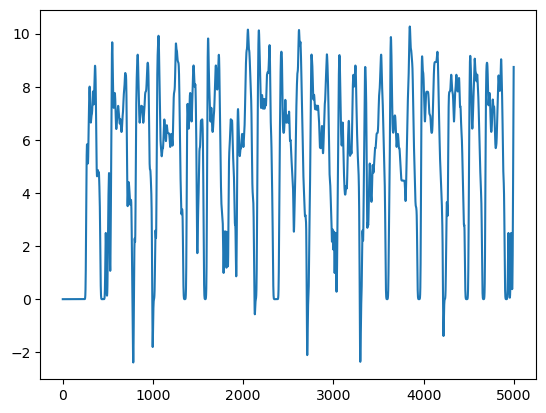

In [55]:
fig,ax = plt.subplots()
ax.plot(speed[:5000])


spks = np.copy(sess.timeseries['channel_0_F_dff'])
sess.add_timeseries(channel_0_F_dff_speed_filt=spks)
spks[:,speed<2]=np.nan
sess.add_pos_binned_trial_matrix('channel_0_F_dff_speed_filt')


spks = np.copy(sess.timeseries['channel_1_F_dff'])
spks[:,speed<2]=np.nan
sess.add_timeseries(channel_1_F_dff_speed_filt=spks)
sess.add_pos_binned_trial_matrix('channel_1_F_dff_speed_filt')


In [56]:
sess.trial_matrices.keys()

dict_keys(['channel_0_F_dff', 'bin_edges', 'bin_centers', 'channel_0_spks', 'channel_1_F_dff', 'channel_1_spks', 'licks', 'speed', 'channel_0_F_dff_speed_filt', 'channel_1_F_dff_speed_filt'])

In [57]:
sess.timeseries.keys()

dict_keys(['channel_0_F', 'channel_0_Fneu', 'channel_1_F', 'channel_1_Fneu', 'channel_0_F_dff', 'channel_0_spks', 'channel_1_F_dff', 'channel_1_spks', 'licks', 'speed', 'channel_0_F_dff_speed_filt', 'channel_1_F_dff_speed_filt'])

In [58]:
sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100)
sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100)

perm 0
perm 0
perm 0
perm 0


In [40]:
# create mask for place cells only 

chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']

chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right

In [41]:
# mask for interneurons
int_mask1 = u.is_putative_interneuron(sess, ts_key='channel_1_F_dff', method='speed',
                            prct=10, r_thresh=0.3)

int_mask0 = u.is_putative_interneuron(sess, ts_key='channel_0_F_dff', method='speed',
                            prct=10, r_thresh=0.3)

chan1_mask = np.logical_and(chan1_mask, int_mask1)
chan0_mask = np.logical_and(chan0_mask, int_mask0)


In [42]:
# add nan values back into trials
reverse_mux_alignment(sess, df_key = 'channel_0_F_dff')
reverse_mux_alignment(sess, df_key = 'channel_1_F_dff')

In [59]:
output_path = os.path.join("C://Users/esay/data/Stx3/YMazeSessPkls/")
tpu.sess.save_session(sess,output_path)

In [70]:
# load 
date='24_05_2025'
session = 4
pkldir = os.path.join('C://Users/esay/data/Stx3/YMazeSessPkls/', mouse,  date, f'{scene}_{session}.pkl')
sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)

In [24]:
def plot_cells(trial_mat, cell_inds=None, n_cols=20):
    '''

    :param ca1:
    :param cell_inds: indices of cells to plot
    :param save_figs:
    :return:
    '''

    if cell_inds is None:
        cell_inds = np.arange(trial_mat.shape[-1])

    n_rows = int(np.ceil(cell_inds.shape[0] / n_cols))
    fig = plt.figure(figsize=[30, 3 * n_rows])
    gs = gridspec(n_rows, n_cols)
    '''
    ES changes: 
    - indexing for pc only indexing error
    '''
    
    # for cell in cell_inds:
    for i, cell in enumerate(cell_inds):
        # col = cell % n_cols
        col = i % n_cols
        # row = int(cell / n_cols)
        row = i //n_cols
        ax = fig.add_subplot(gs[row, col])
        h = ax.imshow(trial_mat[:, :, cell], cmap="magma")

        if col == 0:
            ax.set_xlabel('pos')
            ax.set_ylabel('trial #')
            if row==0:
                plt.colorbar(h,ax=ax)
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    fig.subplots_adjust(hspace=.3)
    return fig

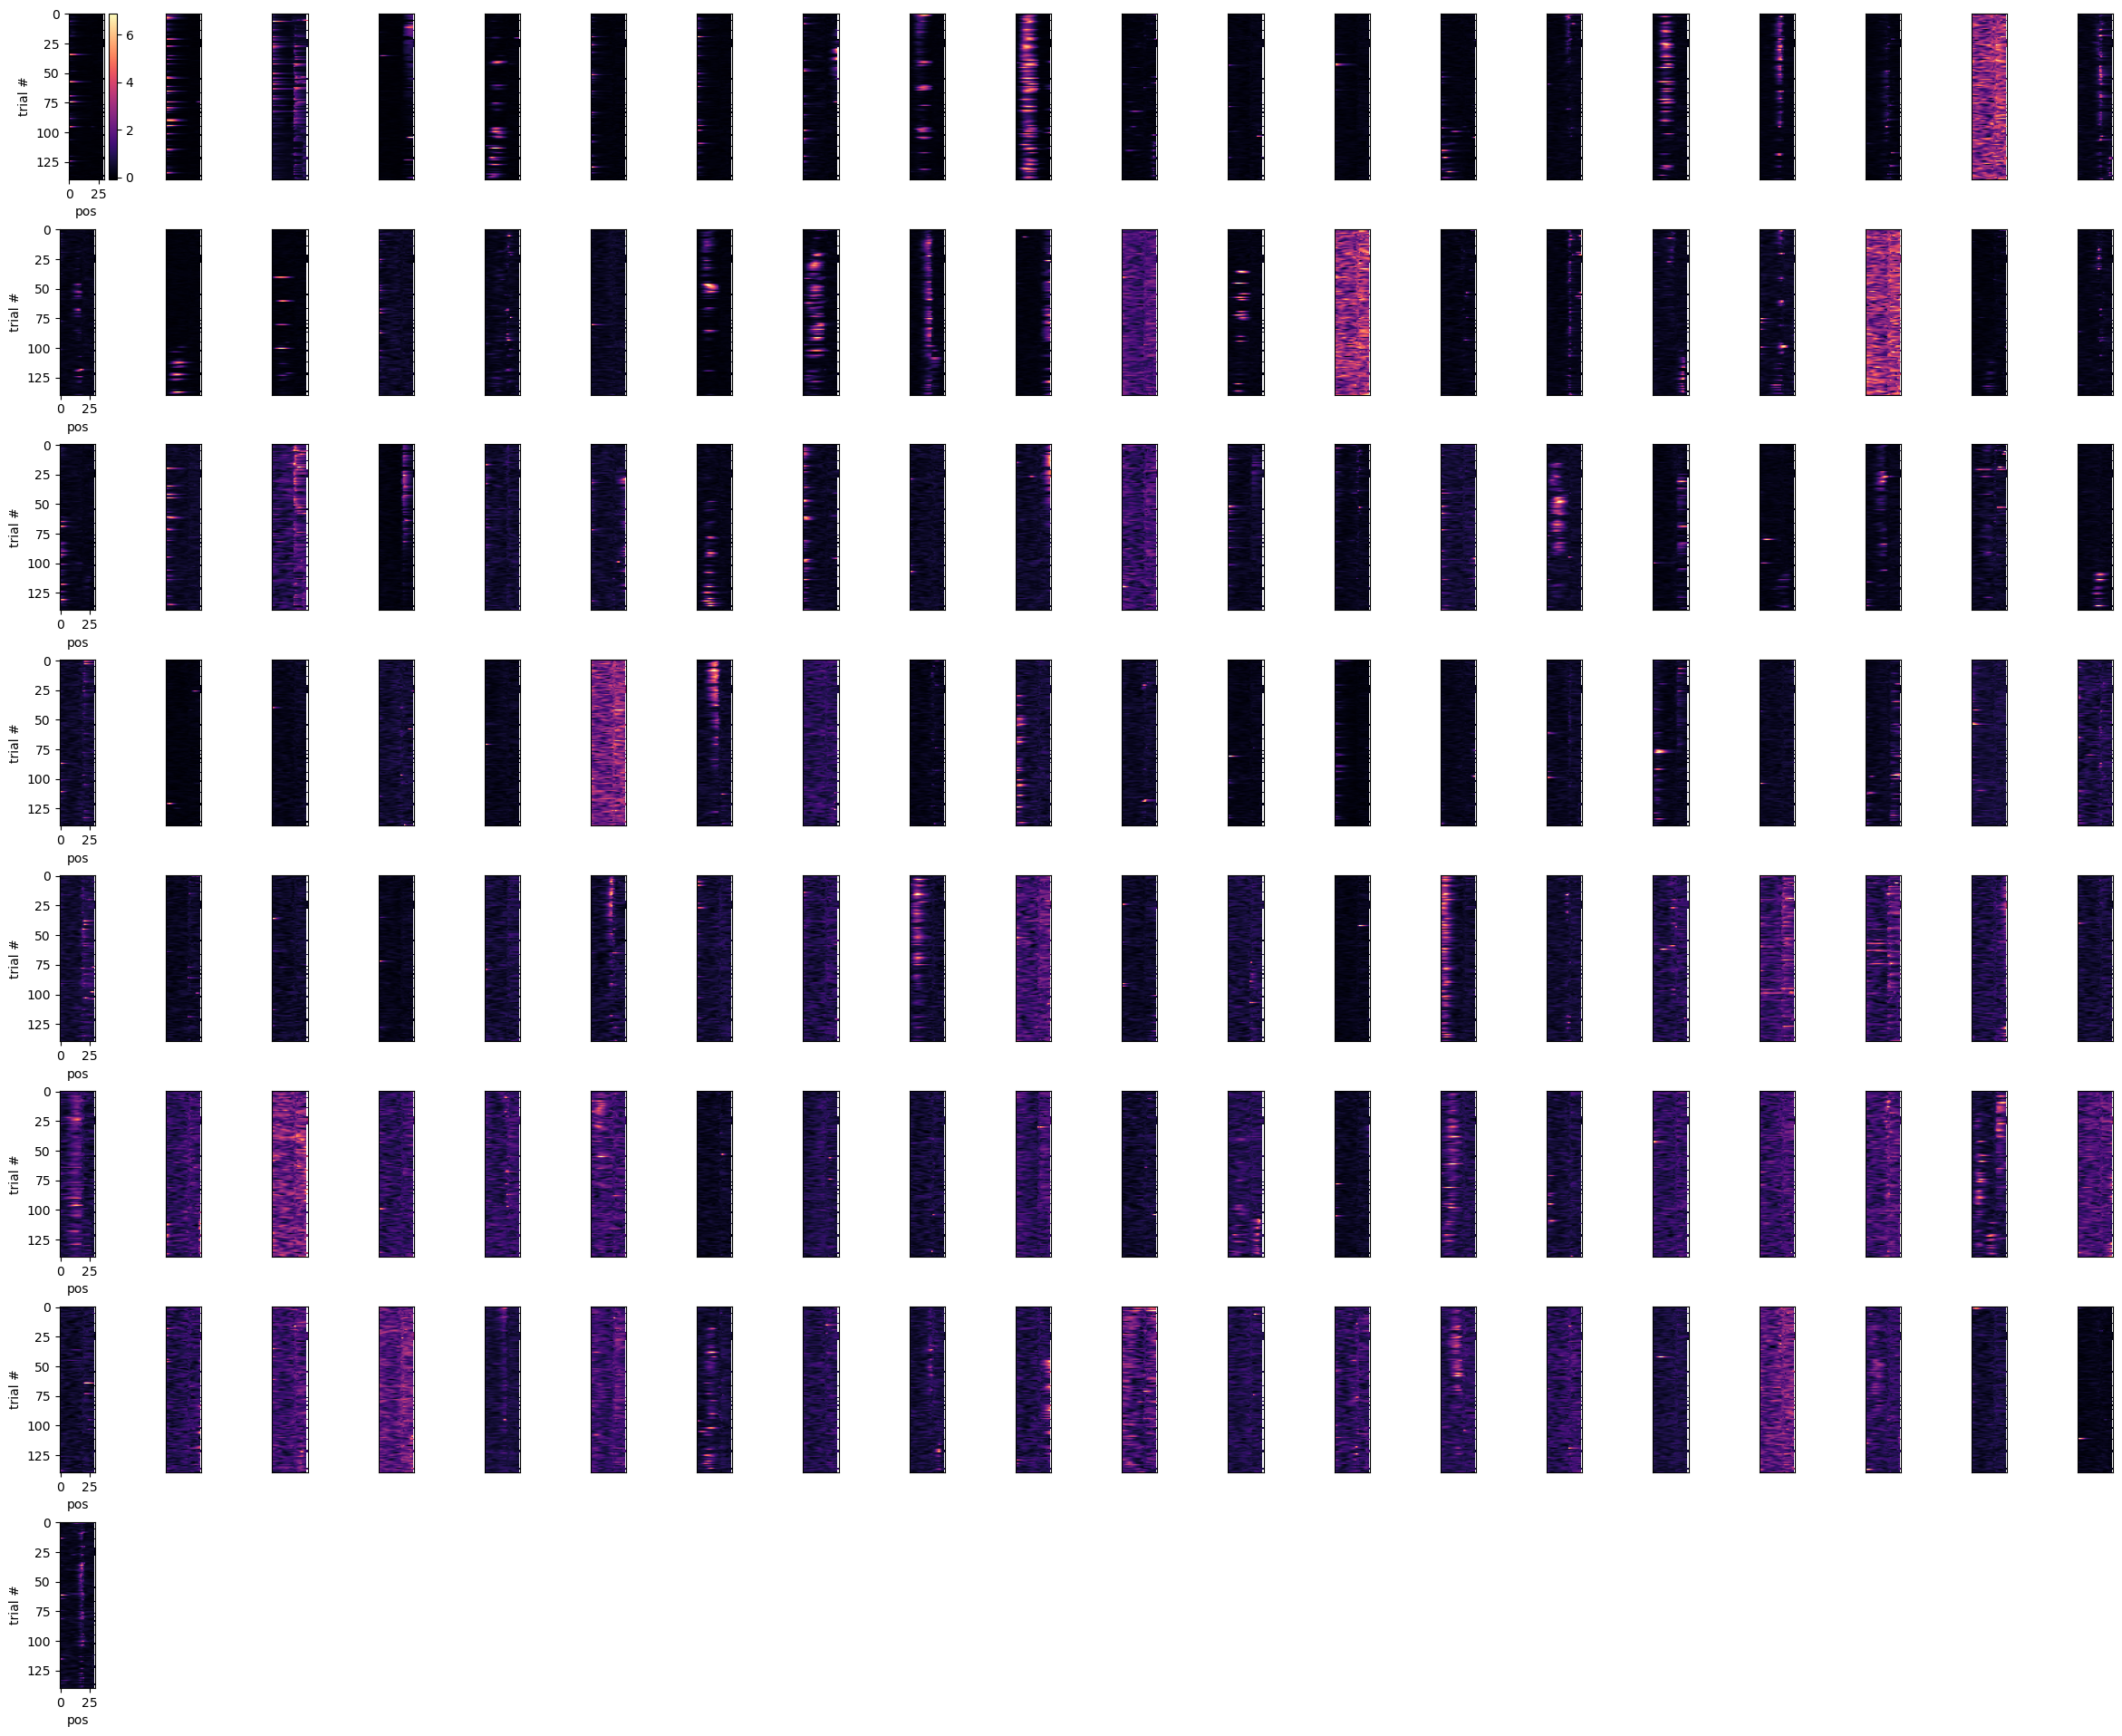

In [44]:
## uncomment to plot only novel trials
# trial_mask = (sess.trial_info['LR']==sess.novel_arm)
tmat = sess.trial_matrices['channel_0_F_dff']
n_cells = tmat.shape[-1]

# plot only place cells using place cell mask
pc_idx = np.where(chan0_mask[:n_cells])[0]
fig = plot_cells(tmat, cell_inds=pc_idx)

# # uncomment to plot all cells
# fig = plot_cells(tmat[trial_mask,:,:], cell_inds=np.array([r for r in range(n_cells)]))

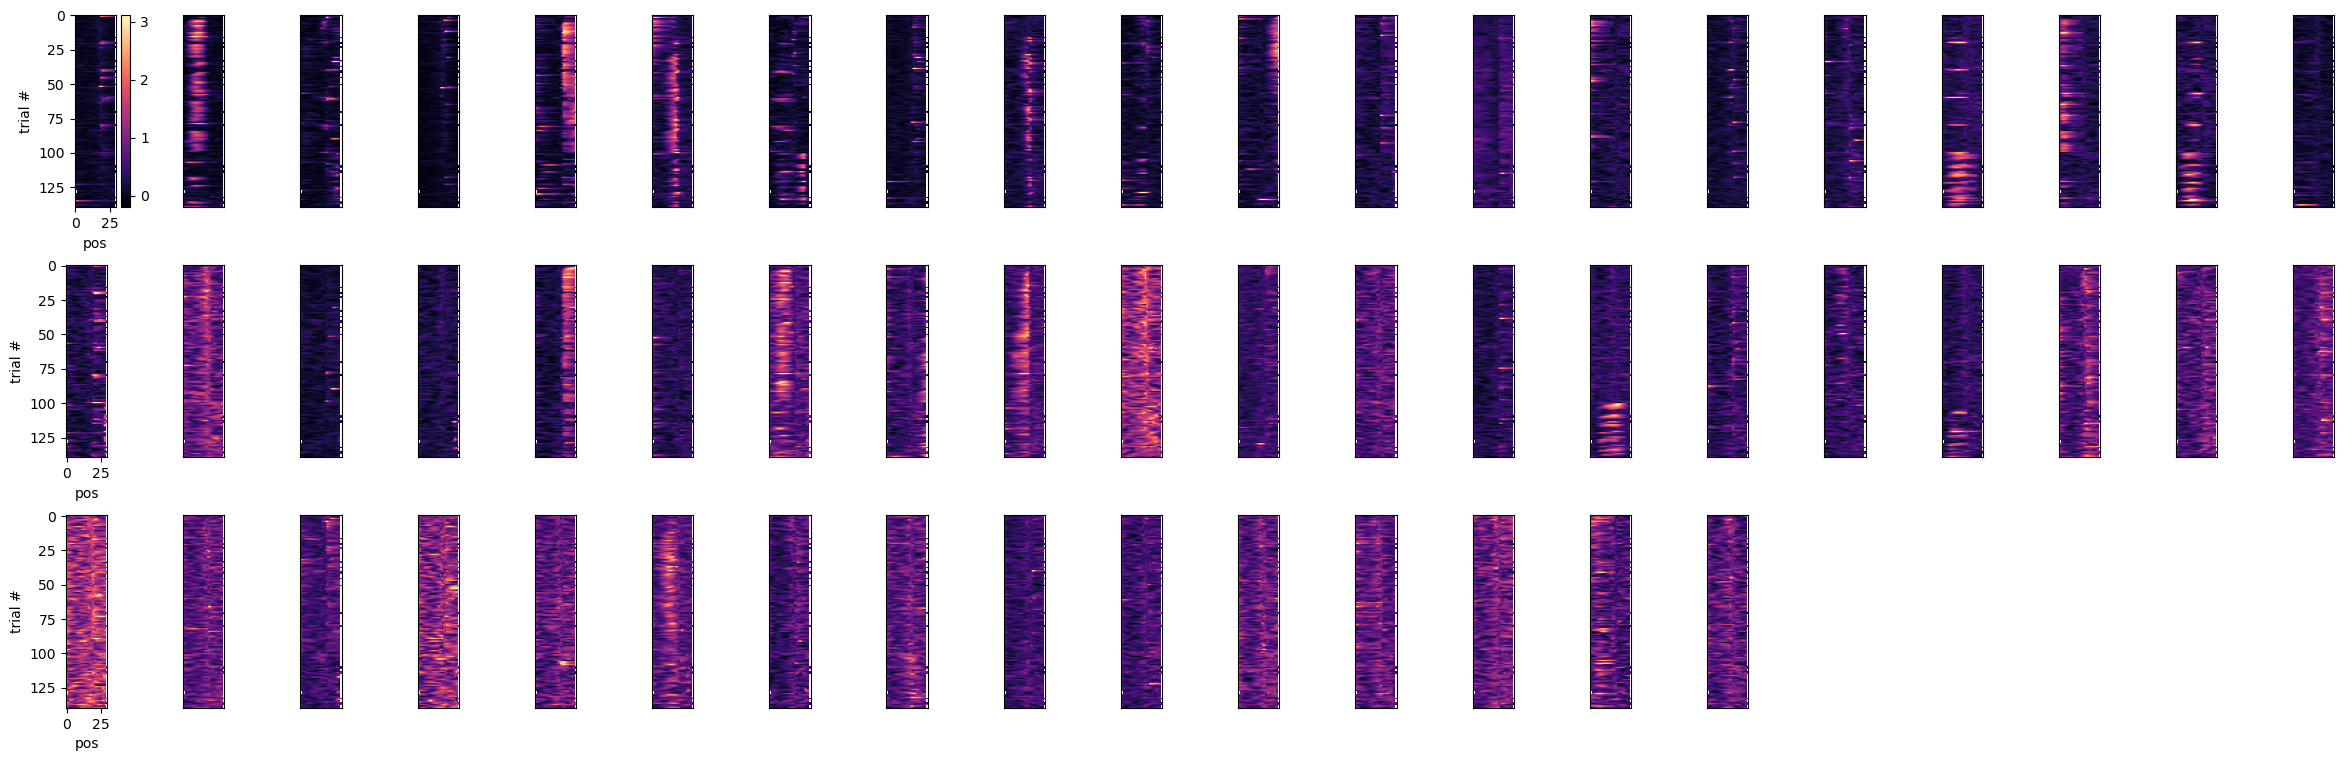

In [27]:
# trial_mask = (sess.trial_info['LR']==sess.novel_arm)*((sess.trial_info['block_number']%2)==0)
tmat = sess.trial_matrices['channel_1_F_dff']
n_cells = tmat.shape[-1]


#place cells only
pc_idx = np.where(chan1_mask[:n_cells])[0]
fig = plot_cells(tmat, cell_inds=pc_idx)

# # all cells
# fig = plot_cells(tmat[trial_mask,:,:], cell_inds=np.array([r for r in range(n_cells)]))

In [82]:
# for mouse in sparse_mice:
mouse = "SparseKO_02"
day = sparse_sessions[mouse][0:-1]
for d in day: 
    print(d)
    date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']
    print(scene)
    # basedir = f'C://Users/esay/data/Stx3/{mouse}/{date}/{scene}'
    stemdir = f'Z://giocomo/esay/Stx3/2pData/{mouse}/{date}/{scene}'
    stem = os.path.join(stemdir, f'{scene}_{session:03}_{scan:03}')
    root = os.path.join(stemdir, f'{scene}_{session:03}_{scan:03}')
    d.update({
        'mouse': mouse,
        'scan_file': root + '.sbx',
        'scanheader_file': root + '.mat',
        'vr_filename': os.path.join("Z://giocomo/esay/Stx3/VRData", mouse, date, "%s_%d.sqlite" % (scene, session)),
        'scan_number': scan,
        'prompt_for_keys': False,
        'VR_only': False,
        'scanner': "NLW",
        'n_channels': 2,
    })

    
    sess = stx.session.YMazeSession(**d)
    sess.load_scan_info(sbx_version=3)
    sess.align_VR_to_2P()
    sess.load_suite2p_data(which_ts=('F', 'Fneu'))
    sess.get_trial_info()

    
    F = sess.timeseries['channel_0_F']
    trial_ts = np.zeros([F.shape[-1], ]) - 1
    blocknum_ts = np.zeros([F.shape[-1], ]) - 1
    for t, (start, stop) in enumerate(zip(sess.trial_start_inds, sess.teleport_inds)):
        trial_ts[start:stop] = t
        blocknum_ts[start:stop] = sess.trial_info['block_number'][t]
    mask_920 = (blocknum_ts % 2 == 0) * (blocknum_ts > 0)
    mask_1040 = (blocknum_ts % 2 == 1) * (blocknum_ts > 0)

    
    sig920 = sess.timeseries['channel_0_F'][:, mask_920].sum(axis=-1)
    sig1040 = sess.timeseries['channel_0_F'][:, mask_1040].sum(axis=-1)
    channel_0_mask = sig920 > sig1040

    
    sess.timeseries['channel_0_F'] = sess.timeseries['channel_0_F'][channel_0_mask, :]
    sess.timeseries['channel_0_Fneu'] = sess.timeseries['channel_0_Fneu'][channel_0_mask, :]
    sig920 = sess.timeseries['channel_1_F'][:, mask_920].sum(axis=-1)
    sig1040 = sess.timeseries['channel_1_F'][:, mask_1040].sum(axis=-1)
    channel_1_mask = sig1040 > sig920

    
    sess.timeseries['channel_1_F'] = sess.timeseries['channel_1_F'][channel_1_mask, :]
    sess.timeseries['channel_1_Fneu'] = sess.timeseries['channel_1_Fneu'][channel_1_mask, :]
    sess.neuropil_corrected_dff(Fkey='channel_0_F', Fneukey='channel_0_Fneu', tau=sess.s2p_ops['channel_0']['tau'], spks_key='channel_0_spks')
    sess.neuropil_corrected_dff(Fkey='channel_1_F', Fneukey='channel_1_Fneu', tau=sess.s2p_ops['channel_1']['tau'], spks_key='channel_1_spks')

    
    sess.add_timeseries(licks=sess.vr_data['lick']._values)
    sess.add_pos_binned_trial_matrix('licks')
    speed = sess.vr_data['dz']._values * sess.scan_info['frame_rate']
    sess.add_timeseries(speed=speed)
    sess.add_pos_binned_trial_matrix('speed')
    
    
    spks = np.copy(sess.timeseries['channel_0_F_dff'])
    spks[:, speed < 2] = np.nan
    sess.add_timeseries(channel_0_F_dff_speed_filt=spks)
    sess.add_pos_binned_trial_matrix('channel_0_F_dff_speed_filt')
    spks = np.copy(sess.timeseries['channel_1_F_dff'])
    spks[:, speed < 2] = np.nan
    
    sess.add_timeseries(channel_1_F_dff_speed_filt=spks)
    sess.add_pos_binned_trial_matrix('channel_1_F_dff_speed_filt')
    
    mask_920 = sess.trial_info['block_number'] % 2 == 0
    sess.place_cells_calc(Fkey='channel_0_spks', out_key='channel_0_spks', nperms=100, trial_mask=mask_920)
    mask_1040 = sess.trial_info['block_number'] % 2 == 1
    sess.place_cells_calc(Fkey='channel_1_spks', out_key='channel_1_spks', nperms=100, trial_mask=mask_1040)
    tpu.sess.save_session(sess, 'C:/Users/esay/data/Stx3/YMazeSessPkls/v2')

{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
YMaze_LNovel
Fixing teleports
frame rate 31.25
(180896,) ttl times,(77898,) ca2+ frame times
last time: VR 2492.7397499999997, ca2+ 2492.704
['Z://giocomo/esay/Stx3/2pData/SparseKO_02/16_11_2024/YMaze_LNovel\\YMaze_LNovel_004_014\\suite2p', 'Z://giocomo/esay/Stx3/2pData/SparseKO_02/16_11_2024/YMaze_LNovel\\YMaze_LNovel_004_014\\chan2/suite2p']


AssertionError: channel_0_F must be the same length as vr_data, channel_0_F 38949, vr 77898 

In [ ]:
 day = sparse_sessions[mouse][0:-1]
    for d in day: 
        print(d)
        date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']
        print(scene)
        # basedir = f'C://Users/esay/data/Stx3/{mouse}/{date}/{scene}'
        stemdir = f'Z://giocomo/esay/Stx3/2pData/{mouse}/{date}/{scene}'
        stem = os.path.join(stemdir, f'{scene}_{session:03}_{scan:03}')
        root = os.path.join(stemdir, f'{scene}_{session:03}_{scan:03}')
        d.update({
            'mouse': mouse,
            'scan_file': root + '.sbx',
            'scanheader_file': root + '.mat',
            'vr_filename': os.path.join("Z://giocomo/esay/Stx3/VRData", mouse, date, "%s_%d.sqlite" % (scene, session)),
            'scan_number': scan,
            'prompt_for_keys': False,
            'VR_only': False,
            'scanner': "NLW",
            'n_channels': 2,
        })

        
        sess = stx.session.YMazeSession(**d)
        sess.load_scan_info(sbx_version=3)
        sess.align_VR_to_2P()
        sess.load_suite2p_data(which_ts=('F', 'Fneu'))
        sess.get_trial_info()

        
        F = sess.timeseries['channel_0_F']
        trial_ts = np.zeros([F.shape[-1], ]) - 1
        blocknum_ts = np.zeros([F.shape[-1], ]) - 1
        for t, (start, stop) in enumerate(zip(sess.trial_start_inds, sess.teleport_inds)):
            trial_ts[start:stop] = t
            blocknum_ts[start:stop] = sess.trial_info['block_number'][t]
        mask_920 = (blocknum_ts % 2 == 0) * (blocknum_ts > 0)
        mask_1040 = (blocknum_ts % 2 == 1) * (blocknum_ts > 0)

        
        sig920 = sess.timeseries['channel_0_F'][:, mask_920].sum(axis=-1)
        sig1040 = sess.timeseries['channel_0_F'][:, mask_1040].sum(axis=-1)
        channel_0_mask = sig920 > sig1040

        
        sess.timeseries['channel_0_F'] = sess.timeseries['channel_0_F'][channel_0_mask, :]
        sess.timeseries['channel_0_Fneu'] = sess.timeseries['channel_0_Fneu'][channel_0_mask, :]
        sig920 = sess.timeseries['channel_1_F'][:, mask_920].sum(axis=-1)
        sig1040 = sess.timeseries['channel_1_F'][:, mask_1040].sum(axis=-1)
        channel_1_mask = sig1040 > sig920

        
        sess.timeseries['channel_1_F'] = sess.timeseries['channel_1_F'][channel_1_mask, :]
        sess.timeseries['channel_1_Fneu'] = sess.timeseries['channel_1_Fneu'][channel_1_mask, :]
        sess.neuropil_corrected_dff(Fkey='channel_0_F', Fneukey='channel_0_Fneu', tau=sess.s2p_ops['channel_0']['tau'], spks_key='channel_0_spks')
        sess.neuropil_corrected_dff(Fkey='channel_1_F', Fneukey='channel_1_Fneu', tau=sess.s2p_ops['channel_1']['tau'], spks_key='channel_1_spks')

        
        sess.add_timeseries(licks=sess.vr_data['lick']._values)
        sess.add_pos_binned_trial_matrix('licks')
        speed = sess.vr_data['dz']._values * sess.scan_info['frame_rate']
        sess.add_timeseries(speed=speed)
        sess.add_pos_binned_trial_matrix('speed')
        
        
        spks = np.copy(sess.timeseries['channel_0_F_dff'])
        spks[:, speed < 2] = np.nan
        sess.add_timeseries(channel_0_F_dff_speed_filt=spks)
        sess.add_pos_binned_trial_matrix('channel_0_F_dff_speed_filt')
        spks = np.copy(sess.timeseries['channel_1_F_dff'])
        spks[:, speed < 2] = np.nan
        
        sess.add_timeseries(channel_1_F_dff_speed_filt=spks)
        sess.add_pos_binned_trial_matrix('channel_1_F_dff_speed_filt')
        
        mask_920 = sess.trial_info['block_number'] % 2 == 0
        sess.place_cells_calc(Fkey='channel_0_spks', out_key='channel_0_spks', nperms=100, trial_mask=mask_920)
        mask_1040 = sess.trial_info['block_number'] % 2 == 1
        sess.place_cells_calc(Fkey='channel_1_spks', out_key='channel_1_spks', nperms=100, trial_mask=mask_1040)
        tpu.sess.save_session(sess, 'C:/Users/esay/data/Stx3/YMazeSessPkls/v2')